In [1]:
import numpy as np
from MLP.model import MLP
import pandas as pd
from MLP.layers import SoftmaxCrossEntropy
from MLP.layers import Adam
from MLP.layers import MiniBatchFit
from MLP.layers import SGDMomentum

# 导入npy数据集
X_train = np.load('Assignment1-Dataset/train_data.npy')
X_test = np.load('Assignment1-Dataset/test_data.npy')
Y_train = np.load('Assignment1-Dataset/train_label.npy').flatten()
Y_test = np.load('Assignment1-Dataset/test_label.npy').flatten()


In [2]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((50000, 128), (50000,), (10000, 128), (10000,))

In [3]:
# 统计数据集的类别
classes = np.unique(Y_train)
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [4]:
def stratified_train_test_split(X, y, test_size=0.2, random_seed=None):
    """
    使用 NumPy 实现的分层抽样训练-测试数据划分。
    
    :param X: 特征数组，形状 (N, d)，N为样本数，d为特征维度
    :param y: 标签数组，形状 (N, )
    :param test_size: 测试集比例（0.0 ~ 1.0）
    :param random_seed: 随机数种子，用于可复现的结果
    :return: (X_train, X_test, y_train, y_test)
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # 找到标签中所有不同类别，以及每个类别出现的索引
    unique_labels = np.unique(y)

    train_indices = []
    test_indices = []

    for label in unique_labels:
        # 找到该类别所有样本的索引
        label_indices = np.where(y == label)[0]
        
        # 打乱该类别索引，防止顺序影响
        np.random.shuffle(label_indices)

        # 计算应该分配到测试集的数量
        test_count = int(len(label_indices) * test_size)
        
        # 前 test_count 个样本分到测试集，其余分到训练集
        test_indices.append(label_indices[:test_count])
        train_indices.append(label_indices[test_count:])

    # 拼接所有类别的索引
    train_indices = np.concatenate(train_indices)
    test_indices = np.concatenate(test_indices)

    # 如果需要进一步打乱train和test索引，可以再做一次shuffle
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)

    # 根据索引切分数据
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

In [5]:
def classification_report_numpy(y_true, y_pred, average='macro'):
    """
    计算多分类 Precision、Recall 和 F1，仅使用 NumPy。
    
    :param y_true: 真实标签，形状 (N,)
    :param y_pred: 预测标签，形状 (N,)
    :param average: 指定平均方式，可选 'macro' 或 'micro'
    :return: (precision, recall, f1)
             - 如果 average='macro'，返回宏平均的 (P, R, F1)
             - 如果 average='micro'，返回微平均的 (P, R, F1)
    """
    # 收集所有类别，并建立索引映射（如果需要）
    classes = np.unique(np.concatenate((y_true, y_pred)))
    num_classes = len(classes)

    # 构建混淆矩阵 confusion matrix
    #  行：真实标签
    #  列：预测标签
    conf_mat = np.zeros((num_classes, num_classes), dtype=np.int64)

    # 如果你的标签不是从0开始的连续整数，需要建立映射
    # 这里假设 classes 已经是从小到大的唯一整数标签
    # 构建 label -> index 的映射字典
    label_to_index = {label: idx for idx, label in enumerate(classes)}
    
    for t, p in zip(y_true, y_pred):
        i = label_to_index[t]
        j = label_to_index[p]
        conf_mat[i, j] += 1

    if average == 'macro':
        # 宏平均：对每个类别计算后再平均
        precisions = []
        recalls = []
        f1s = []
        for i in range(num_classes):
            TP = conf_mat[i, i]
            FP = conf_mat[:, i].sum() - TP  # 该列除对角线外的元素之和
            FN = conf_mat[i, :].sum() - TP  # 该行除对角线外的元素之和

            # 注意分母可能为 0，要做检查
            prec = TP / (TP + FP) if (TP + FP) != 0 else 0.0
            rec = TP / (TP + FN) if (TP + FN) != 0 else 0.0
            f1 = 2 * prec * rec / (prec + rec) if (prec + rec) != 0 else 0.0

            precisions.append(prec)
            recalls.append(rec)
            f1s.append(f1)
        
        precision_macro = np.mean(precisions)
        recall_macro = np.mean(recalls)
        f1_macro = np.mean(f1s)
        return precision_macro, recall_macro, f1_macro

    elif average == 'micro':
        # 微平均：基于全局的 TP, FP, FN 来计算
        TP_total = np.diag(conf_mat).sum()
        # 对每列：列和 - 对角线元素，即所有列上的假正例
        FP_total = conf_mat.sum(axis=0) - np.diag(conf_mat)
        # 对每行：行和 - 对角线元素，即所有行上的假负例
        FN_total = conf_mat.sum(axis=1) - np.diag(conf_mat)
        
        FP_total = FP_total.sum()
        FN_total = FN_total.sum()

        precision_micro = TP_total / (TP_total + FP_total) if (TP_total + FP_total) != 0 else 0.0
        recall_micro = TP_total / (TP_total + FN_total) if (TP_total + FN_total) != 0 else 0.0
        f1_micro = 2 * precision_micro * recall_micro / (precision_micro + recall_micro) \
            if (precision_micro + recall_micro) != 0 else 0.0
        
        return precision_micro, recall_micro, f1_micro

    else:
        raise ValueError("Unsupported average type. Use 'macro' or 'micro'.")

In [6]:
X_train, X_val, Y_train, Y_val = stratified_train_test_split(X_train, Y_train, test_size=0.2, random_seed=42)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((40000, 128), (40000,), (10000, 128), (10000,))

In [7]:
# 每个数据集的种类样本数
pd.Series(Y_train).value_counts(), pd.Series(Y_test).value_counts()


(6    4000
 7    4000
 8    4000
 3    4000
 2    4000
 1    4000
 4    4000
 9    4000
 0    4000
 5    4000
 Name: count, dtype: int64,
 3    1000
 8    1000
 0    1000
 6    1000
 1    1000
 9    1000
 5    1000
 7    1000
 4    1000
 2    1000
 Name: count, dtype: int64)

In [8]:
input_dim = 128  # 输入数据维度
hidden_dims = [64, 32]  # 隐藏层维度
output_dim = 10  # 输出类别数（例如10分类）
#learning_rate = 0.001
momentum = 0.9
num_epochs = 200
batch_size = 100


In [9]:
# 加入进度条
from tqdm import tqdm


# Define hyperparameter search space for Adam
param_grid = {
    'learning_rate': [0.001, 0.005, 0.01],
    'weight_decay': [0.0, 1e-5, 1e-4],
    'dropout_rate': [0.1, 0.2, 0.3]
}

# 统计进度条总数
total_combinations_adam = len(param_grid['learning_rate']) * len(param_grid['weight_decay']) * len(param_grid['dropout_rate'])
# 初始化进度条
adam_tqdm = tqdm(total=total_combinations_adam, desc="Adam Hyperparameter Search", unit="combination")

adam_search_results = []

# Manually iterate over all combinations (no itertools)
for lr in param_grid['learning_rate']:
    for wd in param_grid['weight_decay']:
        for drop in param_grid['dropout_rate']:
            optimizer = Adam()
            model = MLP(input_dim, hidden_dims, output_dim, dropout_rate=drop, weight_decay=wd, optimizer=optimizer)
            trainer = MiniBatchFit(model, optimizer, X_train, Y_train,
                                   output_dim, num_epochs=num_epochs,
                                   batch_size=batch_size,
                                   learning_rate=lr, write = False)
            trainer.fit()
            _, accuracy = model.predict_and_evaluate(X_test, Y_test)
            adam_search_results.append({
                'learning_rate': lr,
                'weight_decay': wd,
                'dropout_rate': drop,
                'test_accuracy': round(accuracy, 4)
            })
            # 更新进度条
            adam_tqdm.update(1)

# 关闭进度条
adam_tqdm.close()

# Save results to DataFrame
adam_result_df = pd.DataFrame(adam_search_results)
adam_result_df = adam_result_df.sort_values(by='test_accuracy', ascending=False).reset_index(drop=True)

# Show top 5 configurations
print("Top 5 Adam Hyperparameter Configurations:")
print(adam_result_df.head())

Adam Hyperparameter Search: 100%|██████████| 27/27 [35:23<00:00, 78.65s/combination]

Top 5 Adam Hyperparameter Configurations:
   learning_rate  weight_decay  dropout_rate  test_accuracy
0          0.001       0.00000           0.1         0.5215
1          0.010       0.00001           0.1         0.5196
2          0.005       0.00000           0.1         0.5183
3          0.001       0.00010           0.1         0.5179
4          0.001       0.00001           0.1         0.5176


In [10]:

best_cfg = adam_result_df.iloc[0]
best_lr = best_cfg['learning_rate']
best_wd = best_cfg['weight_decay']
best_drop = best_cfg['dropout_rate']

# 
optimizer1 = Adam()
model_Adam = MLP(input_dim, hidden_dims, output_dim,
                 dropout_rate=best_drop,
                 weight_decay=best_wd,
                 optimizer=optimizer1)
Adam_Fit = MiniBatchFit(model_Adam, optimizer1,
             X_train, Y_train,
             output_dim,
             num_epochs=num_epochs,
             batch_size=batch_size,
             learning_rate=best_lr)
Adam_Fit.fit()


Epoch 1/200, Loss: 1.9661
Epoch 2/200, Loss: 1.7698
Epoch 3/200, Loss: 1.7163
Epoch 4/200, Loss: 1.6858
Epoch 5/200, Loss: 1.6609
Epoch 6/200, Loss: 1.6450
Epoch 7/200, Loss: 1.6300
Epoch 8/200, Loss: 1.6173
Epoch 9/200, Loss: 1.6038
Epoch 10/200, Loss: 1.5935
Epoch 11/200, Loss: 1.5807
Epoch 12/200, Loss: 1.5743
Epoch 13/200, Loss: 1.5646
Epoch 14/200, Loss: 1.5591
Epoch 15/200, Loss: 1.5473
Epoch 16/200, Loss: 1.5427
Epoch 17/200, Loss: 1.5344
Epoch 18/200, Loss: 1.5257
Epoch 19/200, Loss: 1.5214
Epoch 20/200, Loss: 1.5139
Epoch 21/200, Loss: 1.5098
Epoch 22/200, Loss: 1.5024
Epoch 23/200, Loss: 1.4974
Epoch 24/200, Loss: 1.4906
Epoch 25/200, Loss: 1.4839
Epoch 26/200, Loss: 1.4787
Epoch 27/200, Loss: 1.4745
Epoch 28/200, Loss: 1.4705
Epoch 29/200, Loss: 1.4705
Epoch 30/200, Loss: 1.4616
Epoch 31/200, Loss: 1.4606
Epoch 32/200, Loss: 1.4537
Epoch 33/200, Loss: 1.4484
Epoch 34/200, Loss: 1.4479
Epoch 35/200, Loss: 1.4445
Epoch 36/200, Loss: 1.4402
Epoch 37/200, Loss: 1.4391
Epoch 38/2

In [11]:
predictions_train_Adam, Adam_Train_acc = model_Adam.predict_and_evaluate(X_val, Y_val)
precision_val,recall_val,f1_val = classification_report_numpy(Y_val, predictions_train_Adam, average='macro')
print(f"Validation Accuracy: {Adam_Train_acc:.4f}")
print(f"Validation F1 Score: {f1_val:.4f}")
print(f"Validation Recall: {recall_val:.4f}")
print(f"Validation Precision: {precision_val:.4f}")

Validation Accuracy: 0.5188
Validation F1 Score: 0.5114
Validation Recall: 0.5188
Validation Precision: 0.5153


In [12]:
predictions_test_Adam,Adam_Test_acc = model_Adam.predict_and_evaluate(X_test, Y_test)
precision_test,recall_test,f1_test = classification_report_numpy(Y_test, predictions_test_Adam, average='macro')
print(f"Test Accuracy: {Adam_Test_acc:.4f}")
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")

Test Accuracy: 0.5142
Test F1 Score: 0.5057
Test Recall: 0.5142
Test Precision: 0.5096


In [13]:
SGDM_param_grid = {
    'learning_rate': [0.001, 0.005, 0.01],
    'momentum': [0.5, 0.9],
    'dropout_rate': [0.1, 0.2, 0.3],
    'weight_decay': [0.0, 1e-5, 1e-4]
}

# 统计进度条总数
total_combinations_sgdm = len(SGDM_param_grid['learning_rate']) * len(SGDM_param_grid['momentum']) * \
    len(SGDM_param_grid['dropout_rate']) * len(SGDM_param_grid['weight_decay'])
# 初始化进度条
sgdm_tqdm = tqdm(total=total_combinations_sgdm, desc="SGDM Hyperparameter Search", unit="combination")

SGDM_search_results = []

for lr in SGDM_param_grid['learning_rate']:
    for mom in SGDM_param_grid['momentum']:
        for drop in SGDM_param_grid['dropout_rate']:
            for wd in SGDM_param_grid['weight_decay']:
                optimizer = SGDMomentum(momentum=mom)
                model = MLP(input_dim, hidden_dims, output_dim, dropout_rate=drop, weight_decay=wd, optimizer=optimizer)
                trainer = MiniBatchFit(model, optimizer, X_train, Y_train,
                                       output_dim, num_epochs=num_epochs,
                                       batch_size=batch_size,
                                       learning_rate=lr, write = False)
                trainer.fit()
                _, accuracy = model.predict_and_evaluate(X_test, Y_test)
                SGDM_search_results.append({
                    'learning_rate': lr,
                    'momentum': mom,
                    'dropout_rate': drop,
                    'weight_decay': wd,
                    'test_accuracy': round(accuracy, 4)
                })
                # 更新进度条
                sgdm_tqdm.update(1)

# 关闭进度条
sgdm_tqdm.close()

# Save results to DataFrame
SGDM_result_df = pd.DataFrame(SGDM_search_results)
SGDM_result_df = SGDM_result_df.sort_values(by='test_accuracy', ascending=False).reset_index(drop=True)

# Save best SGDM hyperparameters
best_SGDM_cfg = SGDM_result_df.iloc[0]
best_SGDM_lr = best_SGDM_cfg['learning_rate']
best_SGDM_mom = best_SGDM_cfg['momentum']
best_SGDM_wd = best_SGDM_cfg['weight_decay']
best_SGDM_drop = best_SGDM_cfg['dropout_rate']

print("Top 5 SGDM Hyperparameter Configurations:")
print(SGDM_result_df.head())

SGDM Hyperparameter Search: 100%|██████████| 54/54 [1:01:24<00:00, 68.23s/combination]

Top 5 SGDM Hyperparameter Configurations:
   learning_rate  momentum  dropout_rate  weight_decay  test_accuracy
0          0.010       0.5           0.1       0.00000         0.5233
1          0.005       0.9           0.1       0.00010         0.5229
2          0.010       0.5           0.1       0.00010         0.5192
3          0.005       0.9           0.1       0.00001         0.5183
4          0.005       0.5           0.1       0.00001         0.5178


In [14]:
# === SGDM: Final Model Training with Best Hyperparameters ===

optimizer_SGDM = SGDMomentum(momentum=best_SGDM_mom)

model_SGDM = MLP(input_dim, hidden_dims, output_dim,
                 dropout_rate=best_SGDM_drop,
                 weight_decay=best_SGDM_wd,
                 optimizer=optimizer_SGDM)

SGDM_Fit = MiniBatchFit(model_SGDM, optimizer_SGDM,
                        X_train, Y_train,
                        output_dim=output_dim,
                        num_epochs=num_epochs,
                        batch_size=batch_size,
                        learning_rate=best_SGDM_lr)

SGDM_Fit.fit()


Epoch 1/200, Loss: 2.1423
Epoch 2/200, Loss: 1.9238
Epoch 3/200, Loss: 1.8435
Epoch 4/200, Loss: 1.7982
Epoch 5/200, Loss: 1.7582
Epoch 6/200, Loss: 1.7291
Epoch 7/200, Loss: 1.7044
Epoch 8/200, Loss: 1.6820
Epoch 9/200, Loss: 1.6624
Epoch 10/200, Loss: 1.6473
Epoch 11/200, Loss: 1.6344
Epoch 12/200, Loss: 1.6186
Epoch 13/200, Loss: 1.6066
Epoch 14/200, Loss: 1.5967
Epoch 15/200, Loss: 1.5873
Epoch 16/200, Loss: 1.5797
Epoch 17/200, Loss: 1.5715
Epoch 18/200, Loss: 1.5654
Epoch 19/200, Loss: 1.5551
Epoch 20/200, Loss: 1.5463
Epoch 21/200, Loss: 1.5415
Epoch 22/200, Loss: 1.5344
Epoch 23/200, Loss: 1.5269
Epoch 24/200, Loss: 1.5238
Epoch 25/200, Loss: 1.5155
Epoch 26/200, Loss: 1.5081
Epoch 27/200, Loss: 1.5026
Epoch 28/200, Loss: 1.4984
Epoch 29/200, Loss: 1.4933
Epoch 30/200, Loss: 1.4864
Epoch 31/200, Loss: 1.4811
Epoch 32/200, Loss: 1.4778
Epoch 33/200, Loss: 1.4754
Epoch 34/200, Loss: 1.4674
Epoch 35/200, Loss: 1.4664
Epoch 36/200, Loss: 1.4636
Epoch 37/200, Loss: 1.4561
Epoch 38/2

In [15]:
# Get predictions and ignore accuracy here
y_pred, SGD_Train_acc = model_SGDM.predict_and_evaluate(X_val, Y_val)

# Evaluate metrics
precision_val, recall_val, f1_val = classification_report_numpy(Y_val, y_pred, average='macro')
print(f"Validation Accuracy: {SGD_Train_acc:.4f}")

print(f"Validation F1 Score: {f1_val:.4f}")
print(f"Validation Recall: {recall_val:.4f}")
print(f"Validation Precision: {precision_val:.4f}")


Validation Accuracy: 0.5172
Validation F1 Score: 0.5105
Validation Recall: 0.5172
Validation Precision: 0.5110


In [16]:
y_pred_test, SGD_Test_acc = model_SGDM.predict_and_evaluate(X_test, Y_test)

precision_test, recall_test, f1_test = classification_report_numpy(Y_test, y_pred_test, average='macro')
print(f"Test Accuracy: {SGD_Test_acc:.4f}")

print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")


Test Accuracy: 0.5213
Test F1 Score: 0.5142
Test Recall: 0.5213
Test Precision: 0.5153


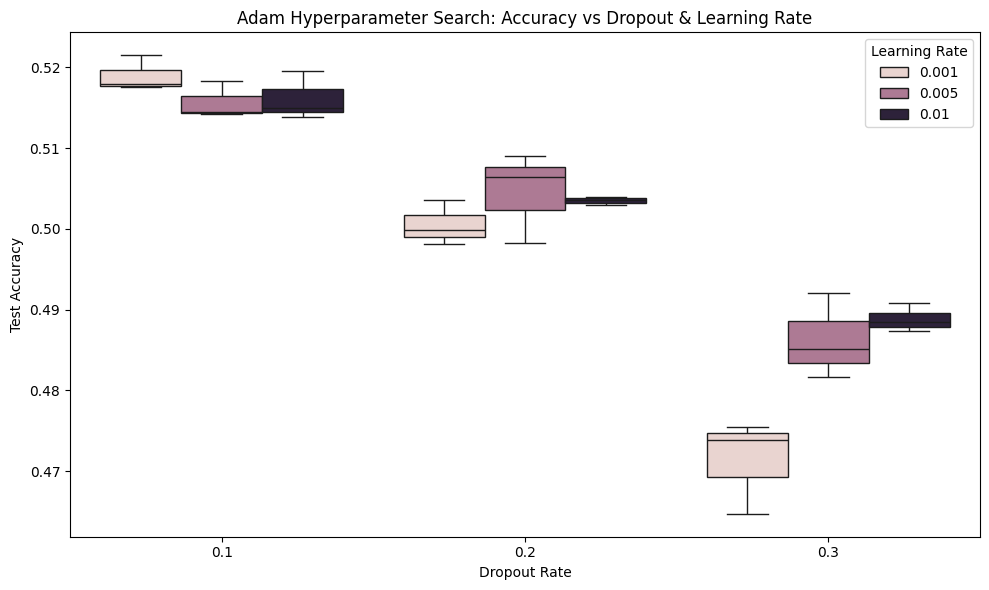

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# === Visualization Section ===
plt.figure(figsize=(10, 6))
sns.boxplot(data=adam_result_df, x='dropout_rate', y='test_accuracy', hue='learning_rate')
plt.title("Adam Hyperparameter Search: Accuracy vs Dropout & Learning Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Test Accuracy")
plt.legend(title="Learning Rate")
plt.tight_layout()
plt.show()


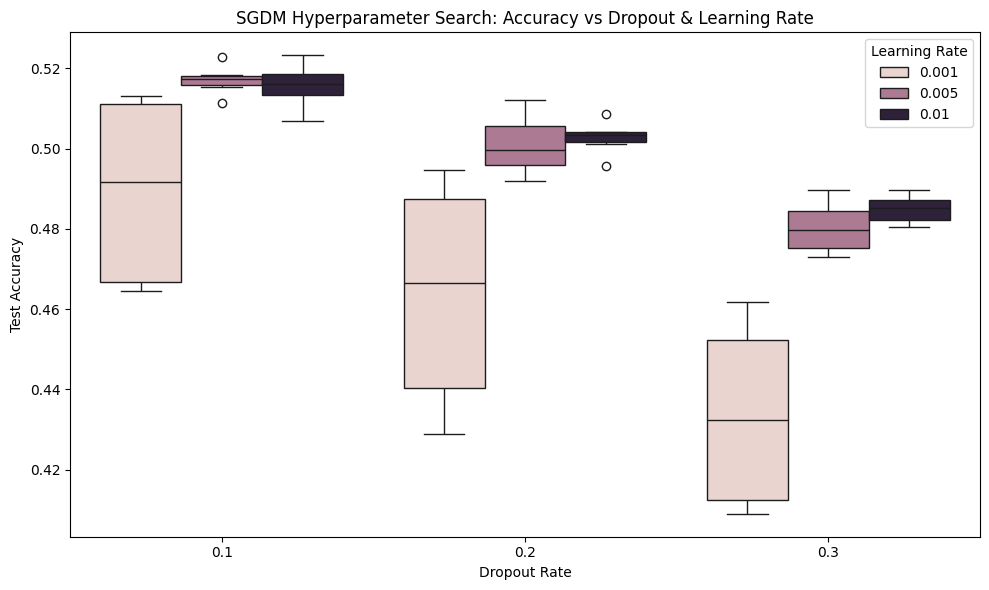

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=SGDM_result_df, x='dropout_rate', y='test_accuracy', hue='learning_rate')
plt.title("SGDM Hyperparameter Search: Accuracy vs Dropout & Learning Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Test Accuracy")
plt.legend(title="Learning Rate")
plt.tight_layout()
plt.show()
